In [1]:
import sys
sys.path.insert(0, '/mnt/afml/finance_ml')
from finance_ml.datasets import datasets
from finance_ml.features import bars

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pylab as plt

In [3]:
code_list = ['122630', '252670', '233740', '251340']  # 레버리지, 200선물인버스2x, 코스닥150레버리지, 코스닥150선물인버스

In [4]:
code = code_list[2]
#df = datasets.load_all_data(code)
df = datasets.load_data(code, '2019-03-22')

In [5]:
df.head()

,shcode,chetime,price,sign,cvolume
dtime,,,,,
2019-03-22 09:00:22,233740,90022,13145,2,129019
2019-03-22 09:00:22,233740,90022,13145,2,934
2019-03-22 09:00:22,233740,90022,13145,2,3271
2019-03-22 09:00:22,233740,90022,13145,2,2320
2019-03-22 09:00:22,233740,90022,13140,2,3410


In [6]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['price'], label = 'Raw prices', ls = '--', color = 'black')
    plt.plot(df_bar.index, df_bar['price'], ls = '', markersize = 10, marker = 'o', label = desc)
    plt.legend()
    plt.show()

100%|██████████| 16302/16302 [00:00<00:00, 647422.11it/s]
/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


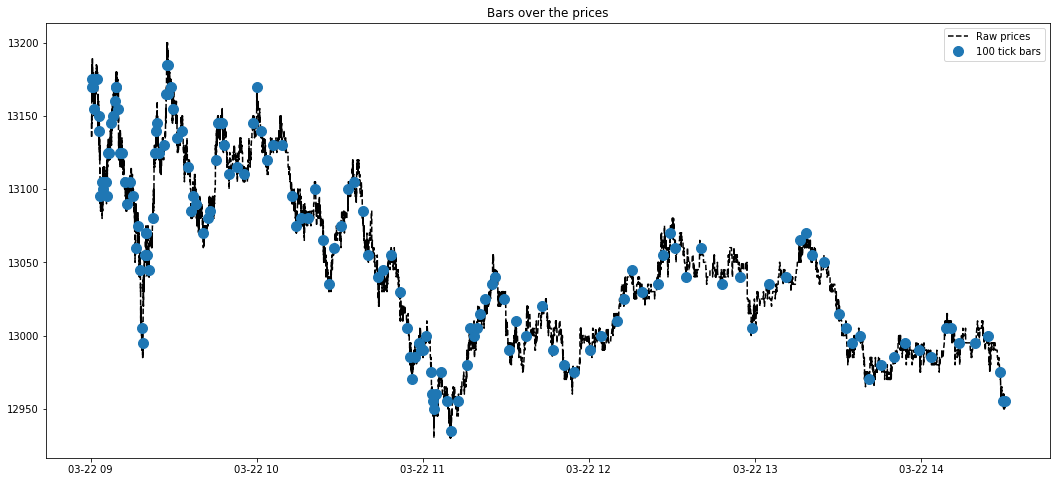

(163, 5)


In [7]:
df_tick = bars.tick_bar_df(df, 'price', 100)
plot_bars(df, df_tick, '100 tick bars')
print(df_tick.shape)

100%|██████████| 16302/16302 [00:00<00:00, 1031320.89it/s]


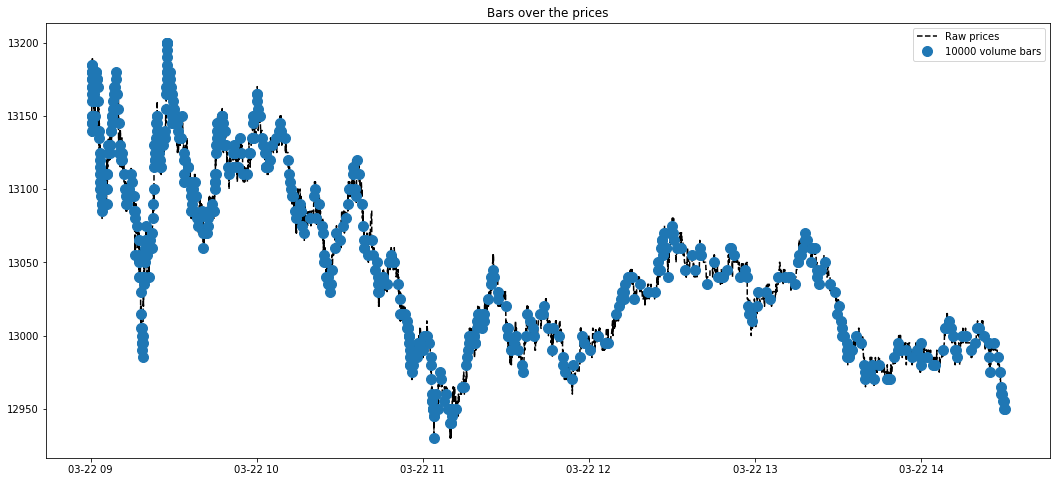

(643, 5)

In [8]:
df_volume = bars.volume_bar_df(df, 'cvolume', 10000)
plot_bars(df, df_volume, '10000 volume bars')
df_volume.shape

100%|██████████| 16302/16302 [00:00<00:00, 769301.80it/s]


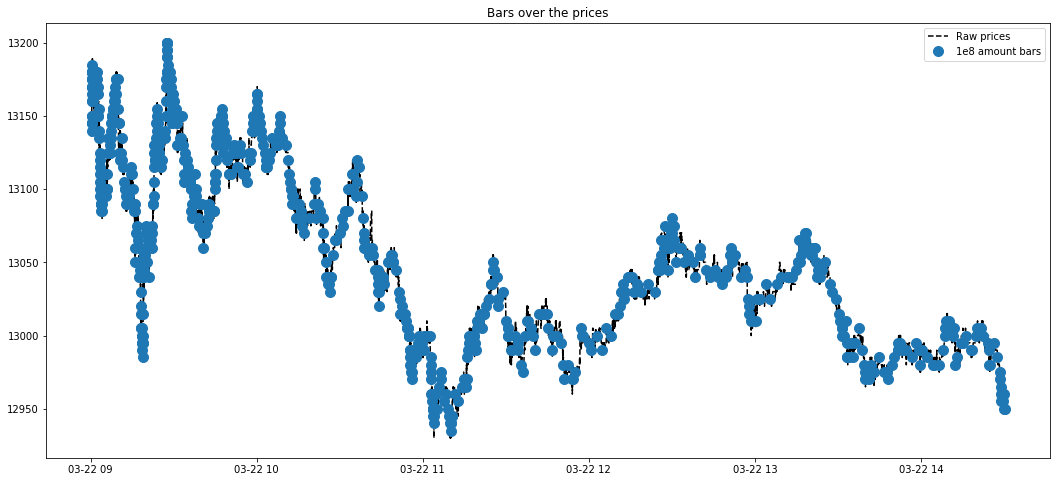

(804, 6)

In [9]:
df['amount'] = df['price']*df['cvolume']
df_dollar = bars.dollar_bar_df(df, 'amount', 1e8)
plot_bars(df, df_dollar, '1e8 amount bars')
df_dollar.shape

100%|██████████| 16202/16202 [00:40<00:00, 401.21it/s]


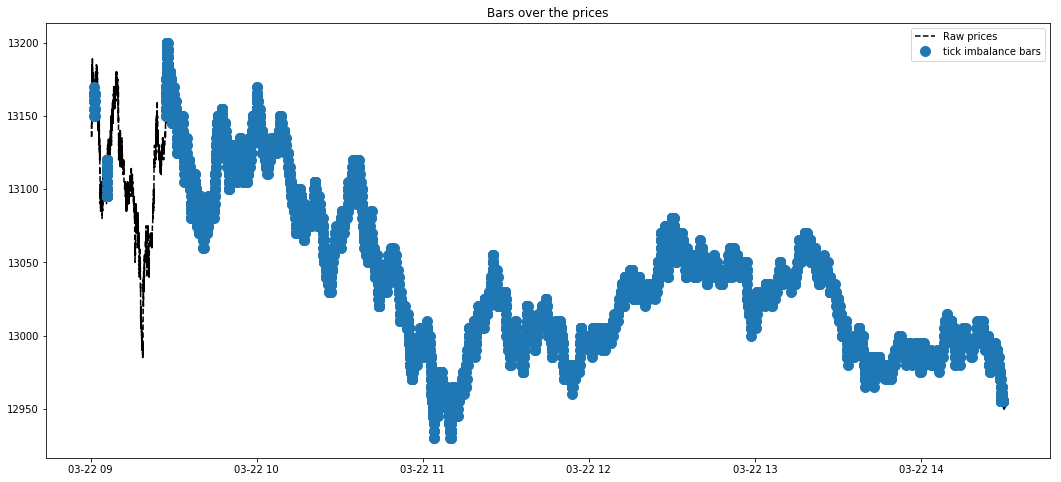

(11798, 6)

In [10]:
df_tib = bars.tib_df(df, 'price')
plot_bars(df, df_tib, 'tick imbalance bars')
df_tib.shape

 29%|██▉       | 4678/16202 [00:00<00:00, 46614.89it/s]

100.0 181.51534533661754


100%|██████████| 16202/16202 [00:39<00:00, 406.95it/s]


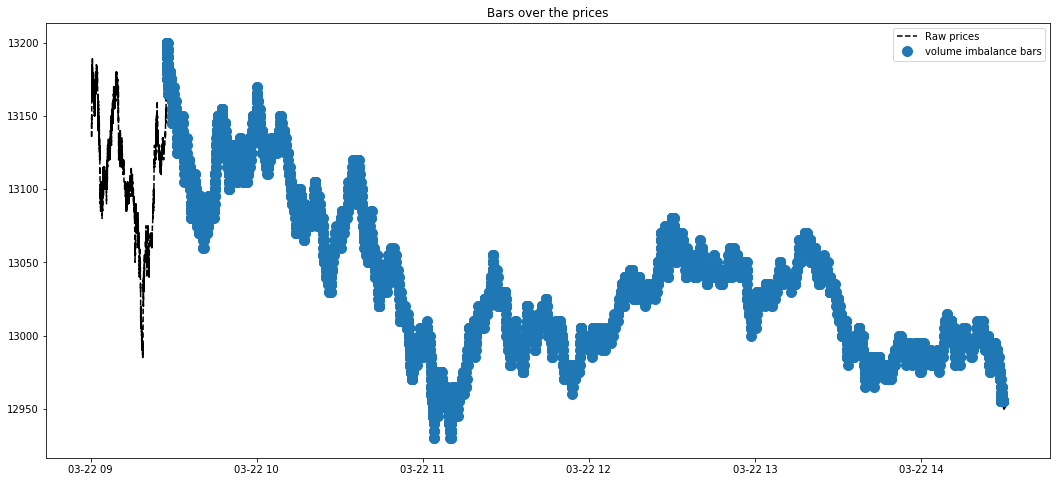

(11570, 6)

In [11]:
df_vib = bars.vib_df(df, 'price', 'cvolume')
plot_bars(df, df_vib, 'volume imbalance bars')
df_vib.shape

In [ ]:
# 위 Imbalance Bar가 오류가 없는지 체크한 후 아래 Run Bar는 다시 구현

def trb(df, column):
    '''
    compute tick imbalance bars

    # args
        df: pd.DataFrame()
        column: name for price data
    # returns
        idx: list of indices
    '''
    if 'bt' not in df.columns:
        df['bt'] = bars.get_imbalance(df[column])
    df['etmbt'] = pd.concat([df['bt'].ewm(alpha=0.5).mean(), -df['bt'].ewm(alpha=0.5).mean()], axis=1).max(axis=1)
    df['trb'] = pd.concat([(df['bt']*(df['bt']==1)).rolling(1000).mean(), (-1*df['bt']*(df['bt']==-1)).rolling(1000).mean()], axis=1).max(axis=1)
    df['etrb'] = df['etmbt']#.rolling(1000).mean()

    idx = []
    for i, x in enumerate(tqdm(df['trb'])):
        if np.abs(x) >= np.abs(df['etrb'][i]):
            idx.append(i)
            continue
    return idx


def trb_df(df, column):
    idx = trb(df, column)
    return df.iloc[idx]


def vrb(df, price_column, volume_column):
    '''
    compute tick imbalance bars

    # args
        df: pd.DataFrame()
        price_column: name for price data
        volume_column: name for volume data
    # returns
        idx: list of indices
    '''
    if 'bt' not in df.columns:
        df['bt'] = bars.get_imbalance(df[price_column])
    df['evmbt'] = pd.concat([(df['bt']*df[volume_column]).ewm(alpha=0.5).mean(),
                              (-df['bt']*df[volume_column]).ewm(alpha=0.5).mean()], axis=1).max(axis=1)
    df['vrb'] = pd.concat([(df['bt']*(df['bt']==1)*df[volume_column]).rolling(1000).mean(), 
                           (-1*df['bt']*(df['bt']==-1)*df[volume_column]).rolling(1000).mean()], axis=1).max(axis=1)
    df['evrb'] = df['evmbt']#.rolling(1000).mean()

    idx = []
    for i, x in enumerate(tqdm(df['vrb'])):
        if np.abs(x) >= np.abs(df['evrb'][i]):
            idx.append(i)
            continue
    return idx


def vrb_df(df, price_column, volume_column):
    idx = vrb(df, price_column, volume_column)
    return df.iloc[idx]



In [ ]:
df_trb = trb_df(df, 'price')
print(df_trb.shape)
df_trb.head()

In [ ]:
df_vrb = vrb_df(df, 'price', 'cvolume')
print(df_vrb.shape)
df_vrb.head()